In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from collections import OrderedDict
from contextlib import redirect_stdout
from datetime import datetime as dt
from math import ceil
from random import shuffle
from shutil import copyfile
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as preprocess_input_inceptionv3
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as preprocess_input_vgg16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.layers import Flatten, TimeDistributed, RepeatVector, Concatenate, BatchNormalization, Input, Dense, Dropout, LSTM, Embedding, Bidirectional, add
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image, sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model

from nltk.translate.bleu_score import corpus_bleu


import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import os
import pandas as pd
import pickle
import random
import string

In [3]:
!wget -nc https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -nc https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

!unzip -o Flickr8k_Dataset.zip
!unzip -o Flickr8k_text.zip -d Flickr8k_text

Streaming output truncated to the last 5000 lines.
  inflating: Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: Flicker8k_Dataset/3429641260_2f035c1813.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429641260_2f035c1813.jpg  
  inflating: Flicker8k_Dataset/3429956016_3c7e3096c2.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429956016_3c7e3096c2.jpg  
  inflating: Flicker8k_Dataset/3430100177_5864bf1e73.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430100177_5864bf1e73.jpg  
  inflating: Flicker8k_Dataset/3430287726_94a1825bbf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430287726_94a1825bbf.jpg  
  inflating: Flicker8k_Dataset/3430526230_234b3550f6.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430526230_234b3550f6.jpg  
  inflating: Flicker8k_Dataset/3430607596_7e4f

In [4]:
!wget -nc http://nlp.stanford.edu/data/glove.6B.zip
!unzip -o glove*.zip -d glove.6B

--2022-02-23 16:21:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-02-23 16:21:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-02-23 16:21:28--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [5]:
images_dir = os.listdir("Flicker8k_Dataset")

images_path = 'Flicker8k_Dataset'
captions_path = 'Flickr8k_text/Flickr8k.token.txt'
train_path = 'Flickr8k_text/Flickr_8k.trainImages.txt'
val_path = 'Flickr8k_text/Flickr_8k.devImages.txt'
test_path = 'Flickr8k_text/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")

images = os.listdir(images_path)
print("The number of jpg files in Flicker8k: {}".format(len(images)))

The number of jpg files in Flicker8k: 8091


In [6]:
# Do not run this cell unless a new experiment is started

exp_root = '23022022-104428' # dt.now().strftime('%d%m%Y-%H%M%S')
drive_path = f'../content/drive/MyDrive/Colab Notebooks/AIML folder/Project/{exp_root}/'

In [28]:
config1 = OrderedDict({
    'experiment_id': 'exp_1',
    'description': 'InceptionV3 feature extractor with LSTM model',
    'model': 'inceptionV3',  # options vgg16 | inceptionV3
    'learning_rate': 1e-4,
    'glove_embedding': True,
    'dropout_rate': 0.04,
    'data_per_batch': 6, # used in data generator
    'epoch': 80,
    'batch_size': 32,
    'validation_freq': 1,
    'model_architecture': 'arch2'
})

config1a = OrderedDict({
    'experiment_id': 'exp_1a',
    'description': 'InceptionV3 feature extractor with dual bi-directional LSTM model',
    'model': 'inceptionV3',  # options vgg16 | inceptionV3
    'learning_rate': 1e-4,
    'glove_embedding': True,
    'dropout_rate': 0.04,
    'data_per_batch': 6, # used in data generator
    'epoch': 80,
    'batch_size': 32,
    'validation_freq': 1,
    'model_architecture': 'arch1'
})

config2 = OrderedDict({
    'experiment_id': 'exp_2',
    'description': 'VGG feature extractor with single LSTM model and word embeddings',
    'model': 'vgg16',  # options vgg16 | inceptionV3
    'learning_rate': 1e-4,
    'glove_embedding': True,
    'dropout_rate': 0.04,
    'data_per_batch': 6, # used in data generator
    'epoch': 80,
    'batch_size': 32,
    'validation_freq': 1,
    'model_architecture': 'arch1'
})

config3 = OrderedDict({
    'experiment_id': 'exp_3',
    'description': 'VGG feature extractor with single LSTM model without embeddings',
    'model': 'vgg16',  # options vgg16 | inceptionV3
    'learning_rate': 1e-4,
    'glove_embedding': True,
    'dropout_rate': 0.04,
    'data_per_batch': 6, # used in data generator
    'epoch': 80,
    'batch_size': 32,
    'validation_freq': 1,
    'model_architecture': 'arch1'
})

config = config1a  # change the config and run everything below this cell

In [29]:
# load the caption file & read it
def load_caption_file(path):
    
    # dictionary to store captions
    captions_dict = {}
    
    # iterate through the file
    for caption in open(path):
    
        tokens = caption.split()
        caption_id, caption_text = tokens[0].split('.')[0], tokens[1:]
        caption_text = ' '.join(caption_text)
        
        # save it in the captions dictionary
        if caption_id not in captions_dict:
            captions_dict[caption_id] = []
        captions_dict[caption_id].append(caption_text)
    return captions_dict

def sanitize_captions(all_caption) :
  new_captions_dict = {}

  # prepare translation table for removing punctuation. third argument is the list of punctuations we want to remove
  table = str.maketrans('', '', string.punctuation)

  for caption_id, captions in captions_dict.items():
    for caption_text in captions:
      # tokenize the caption_text
      caption_text = caption_text.split()
      # convert it into lower case
      caption_text = [token.lower() for token in caption_text]
      # remove punctuation from each token
      caption_text = [token.translate(table) for token in caption_text]
      # remove all the single letter tokens like 'a', 's'
      caption_text = [token for token in caption_text if len(token)>1]
       
      if caption_id not in new_captions_dict:
        new_captions_dict[caption_id] = []

      # store the cleaned captions
      new_captions_dict[caption_id].append('startseq ' + ' '.join(caption_text) + ' endseq')
  return new_captions_dict

def list_split(lst, ratio):
  s = int(ceil(len(lst)*ratio))
  return (lst[:s], lst[s:])
  
# call the function
captions_dict = load_caption_file(captions_path)
new_captions_dict = sanitize_captions(captions_dict)

print(f'total captions found: {len(new_captions_dict)}')

caption_images_list = [ image.split('.')[0] for image in os.listdir(images_path) if image.split('.')[0] in list(new_captions_dict.keys()) ]

# shuffling the list instead of using the txt files for dev and test. 
shuffle(caption_images_list)

train_validate_images, test_images = list_split(caption_images_list, .9)

total captions found: 8092


In [30]:
# extract features from each photo in the directory
def extract_features(directory, image_keys, config):
    # load the model
    if config['model'] == 'vgg16':
      model = VGG16()
      img_size = 224
      preprocess_input = preprocess_input_vgg16
    elif config['model'] == 'inceptionV3':
      model = InceptionV3(weights='imagenet')
      img_size = 299
      preprocess_input = preprocess_input_inceptionv3

    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    # summarize
    print(model.summary())
    
    # extract features from each photo
    features = dict()
    
    for name in tqdm(image_keys, desc='extracting...'):
        
        # load an image from file
        filename = directory + '/' + name + '.jpg'
        image = load_img(filename, target_size=(img_size, img_size))
        
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        # prepare the image for the VGG model
        image = preprocess_input(image)
        
        # get features
        feature = model.predict(image, verbose=0)
        
        # get image id
        image_id = name.split('.')[0]
        
        # store feature
        features[image_id] = feature

    return features

In [31]:
def data_generator(all_captions, all_image_features, image_keys, data_per_batch, desc):
  x1, x2, y = [], [], []
  n = 0
  while True:
    for image in image_keys:
      n+=1
      captions = all_captions[image]
      for caption in captions:
        caption = caption.split()
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(seq)):
          x2_seq, y_seq = seq[:i] , seq[i]
          x2_seq = pad_sequences([x2_seq], maxlen = max_len)[0]
          y_seq = to_categorical([y_seq], num_classes = vocab_len)[0]
          x1.append( all_image_features[image][0] )
          x2.append(x2_seq)
          y.append(y_seq)
      # yield batch
      if n == data_per_batch:
        yield [np.array(x1), np.array(x2)], np.array(y)
        x1, x2, y = [], [], []
        n = 0


In [32]:
train_validate_features = extract_features(images_path, train_validate_images, config)

pickle.dump(train_validate_features, open('./train_validate_features.pkl', 'wb'))

len(train_validate_features)

96124928/96112376 [==============================] - 1s 0us/step
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                

extracting...: 100%|██████████| 7282/7282 [06:56<00:00, 17.49it/s]


7282

In [33]:
# make a dictionary of image with caption for train_validate_images
train_validate_image_caption = {}

for image, caption in new_captions_dict.items():
    
    # check whether the image is available in both train_validate_images list and train_validate_features dictionary
    if image in train_validate_images and image in list(train_validate_features.keys()):        
         train_validate_image_caption.update({image : caption})

# initialise tokenizer
tokenizer = Tokenizer()

# create word count dictionary on the captions list
t = list(train_validate_image_caption.values())
t = [item for sublist in t for item in sublist]
tokenizer.fit_on_texts(t)

# how many words are there in the vocabulary? store the total length in vocab_len and add 1 because word_index starts with 1 not 0 
vocab_len = len(tokenizer.word_index) + 1

# store the length of the maximum sentence
max_len = max( max([len(x.split()) for x in  train_validate_image_caption[image]]) for image in train_validate_image_caption)

print(f'vocab length = {vocab_len}')
print(f'max_len = {max_len}')

config['vocab_length'] = vocab_len
config['max_len'] = max_len

vocab length = 8423
max_len = 34


In [34]:
embedding_index = {}
f = open('./glove.6B/glove.6B.300d.txt', encoding='utf-8')

for line in tqdm(f):
    values = line.split()
    word = values[0]
    co_effs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = co_effs

f.close()
print('Found {} word vectors'.format(len(embedding_index)))

dim_embedding = list(embedding_index.values())[0].shape[0]

embedding_matrix = np.zeros(shape=(vocab_len, dim_embedding))
not_found = []

for word, index in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[index] = embedding_vector
    else:
      not_found.append(word)

print(f'embedding not found for {len(not_found)} words. {not_found}')

400000it [00:22, 18089.41it/s]


Found 400000 word vectors
embedding not found for 921 words. ['startseq', 'endseq', 'tshirt', 'snowcovered', 'rollerblader', 'waterskier', 'upsidedown', 'merrygoround', 'floaties', 'wakeboarder', 'darkhaired', 'dalmation', 'offcamera', 'bicycler', 'tshirts', 'tugofwar', 'brownhaired', 'hulahoops', 'outstreached', 'darkskinned', 'fourwheeler', 'wakeboards', 'africanamerican', 'surfboarder', 'lightcolored', 'somthing', 'treelined', 'corndogs', 'plushie', 'midjump', 'parasails', 'blackandwhite', 'redhaired', 'brightlycolored', 'longnecked', 'threewheeled', 'fencedin', 'facepaint', 'inground', 'middleaged', 'stripy', 'hulahoop', 'windsurfs', 'parasailer', 'grayhaired', 'tugowar', 'retreiver', 'graffiticovered', 'onehanded', 'fingerpaints', 'hiviz', 'gocart', 'drapped', 'waterskies', 'intertube', 'tball', 'waterskis', 'ollies', 'blondehaired', 'blondhaired', '4wheeler', 'rollerskater', 'sveral', 'backgroud', 'frolicks', 'rappels', 'lightup', 'dirtbikes', 'flipflops', 'highfive', 'welldresse

In [35]:
# https://oaji.net/articles/2021/3603-1624925420.pdf
def model_arch1(config, inp_shape, dim_embedding, vocab_len, max_len):

  input_image = Input(shape=(inp_shape,)) 
  i = Dense(dim_embedding, activation='relu')(input_image)
  i = RepeatVector(max_len)(i)

  ## sequence model
  input_txt = Input(shape=(max_len,))
  t = Embedding(vocab_len, dim_embedding, mask_zero=True)(input_txt)
  t = LSTM(dim_embedding, return_sequences=True)(t)
  t = TimeDistributed(Dense(dim_embedding))(t)

  decoder = Concatenate(axis=-1)([t, i])
  decoder = Bidirectional(LSTM(512))(decoder)
  output = Dense(vocab_len, activation='softmax')(decoder)
  
  model = Model(inputs=[input_image, input_txt], outputs=output)

  adam = Adam(learning_rate=config['learning_rate'])
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

  return model

def model_arch2(config, inp_shape, dim_embedding, vocab_len, max_len):
  input_image = Input(shape=(inp_shape,)) 
  fimage = Dense(256, activation='relu', name="ImageFeature")(input_image)
  ## sequence model
  input_txt = Input(shape=(max_len,))
  ftxt = Embedding(vocab_len, dim_embedding, mask_zero=True)(input_txt)
  ftxt = LSTM(256, name="CaptionFeature", return_sequences=True)(ftxt)

  se2 = Dropout(config['dropout_rate'])(ftxt)
  ftxt = LSTM(256, name="CaptionFeature2")(se2)
  # combining model for decoder

  decoder = add([ftxt, fimage])
  decoder = Dense(256, activation="relu")(decoder)
  output = Dense(vocab_len, activation='softmax')(decoder)
  model = Model(inputs=[input_image, input_txt], outputs=output)

  adam = Adam(learning_rate=config['learning_rate'])
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

  return model

def model_arch3(config, inp_shape, dim_embedding, vocab_len, max_len):
  # https://github.com/danieljl/keras-image-captioning
  def categorical_crossentropy_from_logits(y_true, y_pred):
    # Discarding is still needed although CaptionPreprocessor.preprocess_batch
    # has added dummy words as all-zeros arrays because the sum of losses is
    # the same but the mean of losses is different.
    y_true = y_true[:, :-1, :]  # Discard the last timestep/word (dummy)
    y_pred = y_pred[:, :-1, :]  # Discard the last timestep/word (dummy)

    loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    return loss
  
  def categorical_accuracy_with_variable_timestep(y_true, y_pred):
    y_true = y_true[:, :-1, :]  # Discard the last timestep/word (dummy)
    y_pred = y_pred[:, :-1, :]  # Discard the last timestep/word (dummy)

    # Flatten the timestep dimension
    shape = tf.shape(y_true)
    y_true = tf.reshape(y_true, [-1, shape[-1]])
    y_pred = tf.reshape(y_pred, [-1, shape[-1]])

    # Discard rows that are all zeros as they represent dummy or padding words.
    is_zero_y_true = tf.equal(y_true, 0)
    is_zero_row_y_true = tf.reduce_all(is_zero_y_true, axis=-1)
    y_true = tf.boolean_mask(y_true, ~is_zero_row_y_true)
    y_pred = tf.boolean_mask(y_pred, ~is_zero_row_y_true)

    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_true, axis=1),
                                               tf.argmax(y_pred, axis=1)),
                                      dtype=tf.float32))
    return accuracy

  # image
  img_input = Input(shape=(inp_shape,))
  dense_input = BatchNormalization(axis=-1)(img_input)
  image_dense = Dense(units=dim_embedding)(dense_input)
  image_embedding = RepeatVector(1)(image_dense)

  #word
  sentence_input = Input(shape=(max_len,))
  word_embedding = Embedding(vocab_len, dim_embedding, mask_zero=True)(sentence_input)

  sequence_input = add([image_embedding, word_embedding]) # Concatenate(axis=1)([image_embedding, word_embedding])


  rnn_layers = 1
  bidirectional = False
  lstm_size = 256
    
  # sequence model
  for _ in range(rnn_layers):
    input_ = BatchNormalization(axis=-1)(sequence_input)
    rnn = LSTM(lstm_size, return_sequences=True, recurrent_dropout=config['dropout_rate'], implementation=2)
    rnn_out = Bidirectional(rnn)(input_) if bidirectional else rnn(input_)
    input_ = rnn_out
  sequence_output = TimeDistributed(Dense(vocab_len))(rnn_out)

  model = Model(inputs=[img_input, sentence_input], outputs=sequence_output)
  
  model.compile(optimizer=Adam(lr=config['learning_rate'], clipnorm=5.0),
                      loss=categorical_crossentropy_from_logits,
                      metrics=[categorical_accuracy_with_variable_timestep])
  
  return model

# register all known models
registered_architectures = {
    'arch1': model_arch1,
    'arch2': model_arch2,
    #'arch3': model_arch3
}

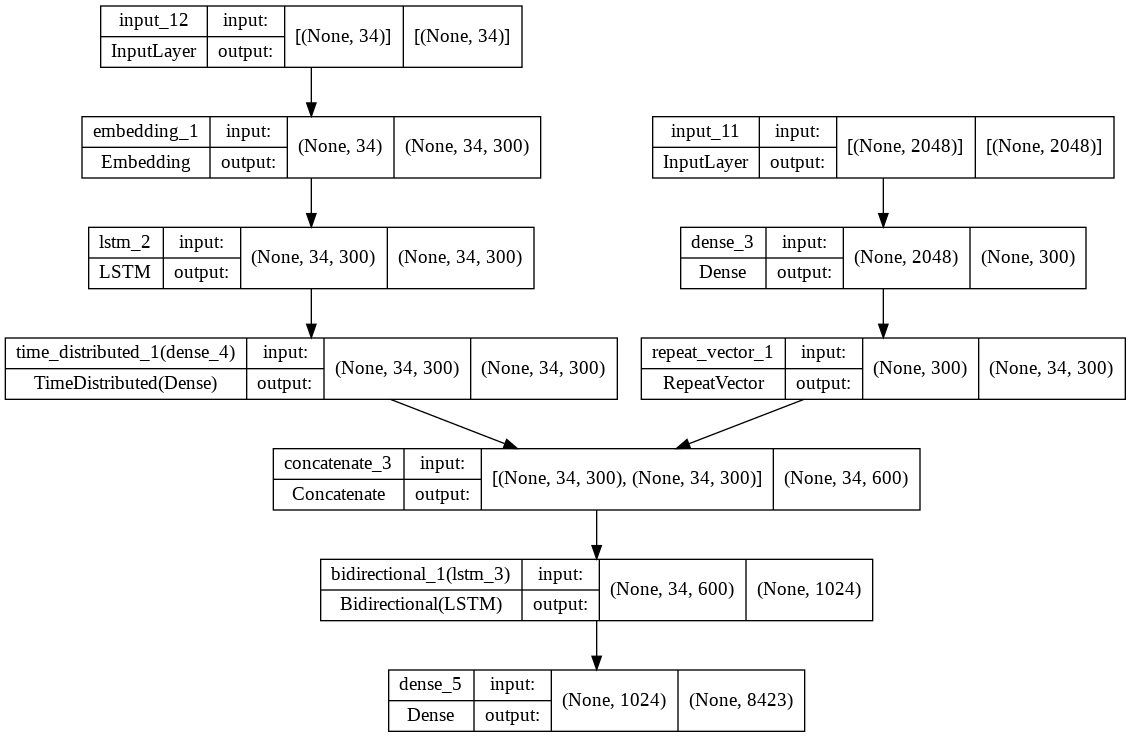

In [36]:

if config['model'] == 'vgg16':
  inp_shape = 4096
elif config['model'] == 'inceptionV3':
  inp_shape = 2048

model = registered_architectures[config['model_architecture']](config, inp_shape, dim_embedding, vocab_len, max_len)

if config['glove_embedding']:
    # freeze embedding layer
    embed = list(filter(lambda x: type(x)==Embedding,  model.layers))
    if len(embed) != 1:
      raise ValueError(f'{len(embed)} number of embedding layers found. This is not supported.')
    embed = embed[0]
    embed.set_weights([embedding_matrix])
    embed.trainable = False

# summarize model
with open('model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

plot_model(model, to_file='model.png', show_shapes=True)

In [37]:
train, val = list_split(train_validate_images, .9)

# train_validate_image_caption   all_captions
# train_validate_features    all_image_features

generator_train = data_generator(train_validate_image_caption, train_validate_features, train, config['data_per_batch'], 'training')
generator_val = data_generator(train_validate_image_caption, train_validate_features, val, config['data_per_batch'], 'validation')

epoch = config['epoch']
batch = config['batch_size']
steps_per_epoch = len(train)//batch
validation_steps = len(val)

#ckpt = ModelCheckpoint(filepath='./model-ep{epoch:02d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5', save_best_only=True, monitor='val_loss')
early_stop = EarlyStopping(monitor="val_loss", min_delta=0, patience=3, verbose=1, restore_best_weights=True)
logger = CSVLogger('./training_history.log')
callbacks = [early_stop, logger]  # ckpt , forced_teacher]

history = model.fit(x = generator_train,
                    validation_data = generator_val,
                    verbose = 1,            
                    epochs = epoch,            
                    callbacks = callbacks,
                    batch_size = batch,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                    validation_freq = config['validation_freq'])

Epoch 1/80
204/204 [==============================] - 88s 384ms/step - loss: 6.1434 - accuracy: 0.1130 - val_loss: 5.5892 - val_accuracy: 0.1357
Epoch 2/80
204/204 [==============================] - 74s 366ms/step - loss: 5.4769 - accuracy: 0.1422 - val_loss: 5.3892 - val_accuracy: 0.1502
Epoch 3/80
204/204 [==============================] - 75s 366ms/step - loss: 5.3366 - accuracy: 0.1544 - val_loss: 5.1754 - val_accuracy: 0.1671
Epoch 4/80
204/204 [==============================] - 74s 366ms/step - loss: 5.0460 - accuracy: 0.1864 - val_loss: 4.9381 - val_accuracy: 0.1972
Epoch 5/80
204/204 [==============================] - 74s 365ms/step - loss: 4.8690 - accuracy: 0.2026 - val_loss: 4.7518 - val_accuracy: 0.2062
Epoch 6/80
204/204 [==============================] - 74s 365ms/step - loss: 4.6223 - accuracy: 0.2168 - val_loss: 4.6080 - val_accuracy: 0.2221
Epoch 7/80
204/204 [==============================] - 74s 365ms/step - loss: 4.4962 - accuracy: 0.2289 - val_loss: 4.4781 - val_ac

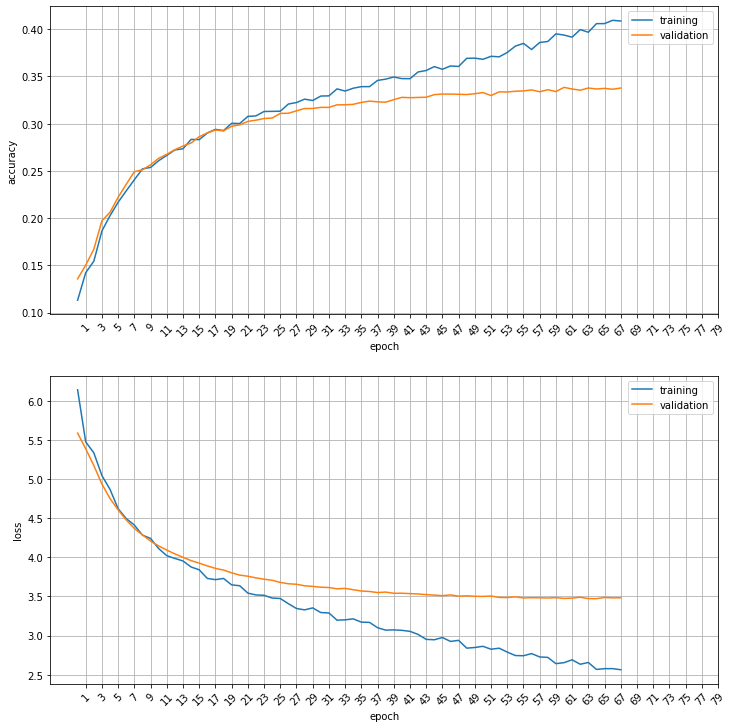

In [38]:
# GOOGLE
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  # ax.set_title(f'model {title} for experiment_id: {config["experiment_id"]}')
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.set_xticks(list(range(1, config['epoch'], 2)))
  ax.tick_params(axis='x', labelrotation=45)
  ax.grid()
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)
plt.savefig('graph.png', dpi=100, bbox_inches='tight')
plt.show()

In [39]:
# extract features from each photo in the directory
def extract_feat(filename):
    # load the model
    model = None
    if config['model'] == 'vgg16':
      model = VGG16(weights='imagenet')
      img_size = 224
      preprocess_input = preprocess_input_vgg16
    elif config['model'] == 'inceptionV3':
      model = InceptionV3(weights='imagenet')
      img_size = 299
      preprocess_input = preprocess_input_inceptionv3
    else:
      raise AttributeError('model type not recognised')
    
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(img_size, img_size))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# map an integer to a word
def word_for_id(integer, tokenizr):
    for word, index in tokenizr.word_index.items():
        if index == integer:
            return word
    return None

In [40]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [41]:
# https://www.kaggle.com/abhinav99ash29/image-captioning-system-with-beam-search
# Beam search based description generation
def beam_generate_desc(model, tokenizer, photo, max_length, beam_idx):
    in_text = 'startseq'
    k=beam_idx
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    yhat = model.predict([photo,sequence], verbose=0)
    yhat = yhat[0].argsort()[::-1][:k]
    words=[]
    for i in range(k):
        words.append(word_for_id(yhat[i], tokenizer))
    in_text = list(list())
    in_text = [['startseq'] for i in range(k)]
    for i in range(k):
        in_text[i].append(words[i])
    for p in range(max_length-1):
        total_seq = []
        for i in range(k):
            if(in_text[i][-1]=='endseq'):
                continue
            sequence = tokenizer.texts_to_sequences([' '.join(in_text[i])])[0]
            sequence = pad_sequences([sequence], maxlen=max_length)
            yhat = model.predict([photo,sequence], verbose=0)
            yhat = np.argmax(yhat)
            word = word_for_id(yhat, tokenizer)
            in_text[i].append(word)
    return in_text

In [42]:

def evaluate_model(model, test_features, all_captions, tokenizer, max_length):
    actual, predicted = list(), list()
    for key in tqdm(test_features, desc='greedy calculation...'):
        photo = test_features[key]
        des = all_captions[key]
        references = [x.split()[1:-1] for x in des]
        yhat = generate_desc(model, tokenizer, photo, max_length)
        # store actual and predicted
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    return corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)), \
           corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)), \
           corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)), \
           corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))


# evaluate the skill of the model for beam
def evaluate_model_beam(model, test_features, all_captions, tokenizer, max_length, beam_idx=3):
    actual, predicted = list(), list()
    for key in tqdm(test_features, desc='beam calculation...'):
        photo = test_features[key]
        yhat = beam_generate_desc(model, tokenizer, photo, max_length, beam_idx)
        des = all_captions[key]
        references = [x.split()[1:-1] for x in des]
        for yhat1 in yhat:
            # store actual and predicted
            actual.append(references)
            predicted.append(yhat1)
    # calculate BLEU score
    return corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)), \
           corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)), \
           corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)), \
           corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

In [43]:
tests_feats = extract_features(images_path, test_images, config)

greedy_eval = evaluate_model(model, tests_feats, new_captions_dict, tokenizer, max_len)
beam_eval = evaluate_model_beam(model, tests_feats, new_captions_dict, tokenizer, max_len, 3)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                          

beam calculation...: 100%|██████████| 809/809 [22:44<00:00,  1.69s/it]


In [44]:

def get_title(ori, pred_greedy, pred_beam_3):
  ori = '\n'.join([' '.join(x.split()[1:-1]) for x in ori])
  pred_greedy = ' '.join(pred_greedy.split()[1:-1])
  pred_beam_3 = '\n'.join([' '.join(x[1:-1]) for x in pred_beam_3])
  return f"""**ORI**
{ori}
**PRED GREEDY**
{pred_greedy}
**PRED BEAM (k=3)**
{pred_beam_3}"""

fig = plt.figure(figsize=(10,20),dpi=200)
idx=1
images=test_images[:5]
for img in images:
  path = '{}.jpg'.format(images_path+'/'+img)
  photo = extract_feat(path)
  rows=len(images)
  ori = new_captions_dict[img]
  pred_greedy = generate_desc(model, tokenizer, photo, max_len)
  pred_beam_3 = beam_generate_desc(model, tokenizer, photo, max_len, 3)

  ax = fig.add_subplot(rows, 2, idx, xticks=[], yticks=[])    
  ax.imshow(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))
  ax.set_title(os.path.basename(img))
  idx+=1

  t = get_title(ori, pred_greedy, pred_beam_3)

  ax = fig.add_subplot(rows, 2, idx)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0,1)
  ax.text(0,0.5, t, fontsize=10)

  idx+=1

plt.savefig('examples.png', dpi=100, bbox_inches='tight')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [45]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model.save('./latest_model')
model.save('./latest_model.h5')


INFO:tensorflow:Assets written to: ./latest_model/assets


INFO:tensorflow:Assets written to: ./latest_model/assets


In [46]:
# write the config used till now before updating the result values
with open('./config.json', 'w') as f:
  json.dump(config, f)

# update config to be written later
config['Greedy BELU-1'] = greedy_eval[0]
config['Greedy BELU-2'] = greedy_eval[1]
config['Greedy BELU-3'] = greedy_eval[2]
config['Greedy BELU-4'] = greedy_eval[3]

config['Beam BELU-1'] = beam_eval[0]
config['Beam BELU-2'] = beam_eval[1]
config['Beam BELU-3'] = beam_eval[2]
config['Beam BELU-4'] = beam_eval[3]

In [47]:
exp_path = f"{drive_path}{config['experiment_id']}/"
os.makedirs(exp_path, exist_ok = True)

# create or update experiment folder
experiment_log_file = f'{drive_path}experiment_results.csv'

cf = config.pop('experiment_id')
df = pd.DataFrame(config, index = [cf])
df.index.name = 'experiment_id'

sep=','
if os.path.exists(experiment_log_file):
  df.to_csv(experiment_log_file, sep=sep, mode='a', index=True, header=False)
else:
  df.to_csv(experiment_log_file, sep=sep, index=True, header=True)

copyfile('./config.json', f"{exp_path}config.json")
copyfile('./tokenizer.pickle', f"{exp_path}tokenizer.pickle")
copyfile('./train_validate_features.pkl', f"{exp_path}train_validate_features.pkl")
copyfile('./latest_model.h5', f"{exp_path}latest_model.h5")
copyfile('./model.png', f"{exp_path}model.png")
copyfile('./graph.png', f"{exp_path}graph.png")
copyfile('./examples.png', f"{exp_path}examples.png")
copyfile('./training_history.log', f"{exp_path}training_history.log")
copyfile('./model_summary.txt', f"{exp_path}model_summary.txt")

'../content/drive/MyDrive/Colab Notebooks/AIML folder/Project/23022022-104428/exp_1a/model_summary.txt'

In [48]:
# loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)